In [26]:
%load_ext autoreload
%autoreload 2
import numpy as np
from obspy import UTCDateTime
from matplotlib import pyplot as plt
import ground_motion_qh
from ground_motion_qh.get_waveforms import get_stream_multiple_stations, raw_stream_to_amplitude_and_times
import os
from pathlib import Path
from pprint import pprint
import pickle

base_dir = Path(ground_motion_qh.__file__).parent.parent

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [27]:
import pandas as pd
# ADD YOUR PICKS HERE:
#!!!!specify station and pickfile!!!!
stn='KNW'
#pick_fn='/home/yiwasak2/QuakeHack/GroundMotion_QH/All_magnitude.csv'
pick_fn='/home/yiwasak2/RECAST2/Picks/SAF/Single_station/QuakeHack/All_magnitude_minmag-1.0_KNW.csv'

#specify minimum magnitude
min_mag=2.0

#waveform will be saved in the following directory
download_name = "ANZA_%s_1994_M%.1f_Picks" % (stn,min_mag)

In [28]:

pick_df=pd.read_csv(pick_fn, index_col=0)
pick_df=pick_df[(pick_df['mag']>=min_mag)]
for index,row in pick_df.iterrows():
    pick_df.loc[index,'time']=UTCDateTime(row['time'])

pick_times = pick_df['time'].values #...or whatever as a numpy datetime array
print(pick_df)

         id                         time  pstime       mag            amp  \
68       68  2015-01-10T23:29:03.905714Z    4.51  2.455233  134825.000000   
118     118  2015-01-18T13:23:44.797143Z    6.39  3.361051  343233.000000   
122     122  2015-01-18T15:52:26.805714Z    6.33  2.052887    3753.961794   
151     151  2015-01-22T15:53:57.425714Z    4.86  2.016932   10745.383909   
169     169  2015-01-25T17:37:22.674286Z    5.15  2.421546   49507.000000   
...     ...                          ...     ...       ...            ...   
18513  4989  2023-12-04T18:24:13.478571Z    4.56  2.468508  139010.000000   
18528  5004  2023-12-07T20:11:53.852857Z    3.55  2.073499   91981.000000   
18586  5062  2023-12-20T20:07:39.320000Z    4.83  2.013725   11029.265266   
18594  5070  2023-12-23T15:42:09.034286Z    5.92  2.371810   44150.000000   
18645  5121  2023-12-31T10:08:43.717143Z    5.41  2.306997   20236.000000   

         p_prob    s_prob   mod_amp                    amp_time1  \
68     

In [29]:


# check if the folder already exists in the raw data folder
data_dir = base_dir / "data" / "raw_data" / download_name
if data_dir.exists():
    print(f"Folder {download_name} already exists in the raw data folder.")

# MAKE SURE TO CHANGE STATION LOCATION ALONG WITH THE STATION NAME!
station_metadata = dict(
    stname = [ stn ],
    network = "AZ",
    org = "IRIS",
    latitude = 33.7141,
    longitude = -116.7119,
    start_time = '1982-10-01',
    number_of_tries = 2,
)

# explanation of buffers:

# (hypocenter) t1                                                                                            t2
# t0 time shift    pre-buffer     event time window     mid buffer     forecast time window      post buffer
# |------------||--------------||-------------------||--------------||---------- ... ---------||-------------|

analysis_metadata = dict(
    mid_buffer = 20,
    forecast_time_window = 60*60,
    event_time_window = 30,
    shift_times = False,
)

analysis_metadata["pre_buffer"] = 3*0.05 * analysis_metadata["forecast_time_window"] + analysis_metadata["event_time_window"] + analysis_metadata["mid_buffer"]
analysis_metadata["post_buffer"] = 3*0.05 * analysis_metadata["forecast_time_window"] + analysis_metadata["event_time_window"] + analysis_metadata["mid_buffer"]


In [30]:
pprint(analysis_metadata, width=1)

{'event_time_window': 30,
 'forecast_time_window': 3600,
 'mid_buffer': 20,
 'post_buffer': 590.0000000000001,
 'pre_buffer': 590.0000000000001,
 'shift_times': False}


In [31]:
metadata = dict(
    analysis_metadata = analysis_metadata,
    station_metadata = station_metadata,
)

# create a data directory with and save the metadata
data_dir = base_dir / "data" / "raw_data" / download_name
os.makedirs(data_dir, exist_ok=True)
np.save(data_dir / "metadata.npy", metadata)

In [32]:
minus_time_range = [
    analysis_metadata["pre_buffer"],
    analysis_metadata["pre_buffer"] + analysis_metadata["event_time_window"]
]

plus_time_range = [
    analysis_metadata["pre_buffer"] + analysis_metadata["event_time_window"]+ analysis_metadata["mid_buffer"],
    analysis_metadata["pre_buffer"] + analysis_metadata["event_time_window"] + analysis_metadata["mid_buffer"] +analysis_metadata["forecast_time_window"]
]

In [33]:
print(pick_times.size)
print(pick_times)

1313
[UTCDateTime(2015, 1, 10, 23, 29, 3, 905714)
 UTCDateTime(2015, 1, 18, 13, 23, 44, 797143)
 UTCDateTime(2015, 1, 18, 15, 52, 26, 805714) ...
 UTCDateTime(2023, 12, 20, 20, 7, 39, 320000)
 UTCDateTime(2023, 12, 23, 15, 42, 9, 34286)
 UTCDateTime(2023, 12, 31, 10, 8, 43, 717143)]


In [34]:
a_max_minus = []
a_max_plus = []

#while i<pick_times.size:
for i, t1 in enumerate(pick_times):
    print(f"Dowloading event {i}: {t1}")
    
    """ t2 = np.datetime64(t1) + np.timedelta64(
        int(  # (QUAKE) HACK
            analysis_metadata["pre_buffer"]
            + analysis_metadata["event_time_window"]
            + analysis_metadata["mid_buffer"]
            + analysis_metadata["forecast_time_window"]
            + analysis_metadata["post_buffer"]
        ),"s",
    ) """
    t1 = t1 - analysis_metadata["pre_buffer"]
    t2 = t1 + int(  # (QUAKE) HACK
            analysis_metadata["pre_buffer"]
            + analysis_metadata["event_time_window"]
            + analysis_metadata["mid_buffer"]
            + analysis_metadata["forecast_time_window"]
            + analysis_metadata["post_buffer"]
        )
    

    # preprocess the waveforms
    i = 0
    while i < station_metadata["number_of_tries"]:
        try:
            stream_dict = get_stream_multiple_stations(
                station_list=[stn],
                t1=UTCDateTime(t1),
                t2=UTCDateTime(t2),
            )
            print(stream_dict)
            tmp_stream=stream_dict[stn]
            tmp_stream
            #stream_dict[stn].plot()
            event_dir = data_dir / f"data/{t1.strftime('%Y-%m-%d_%H-%M-%S')}"

            os.makedirs(event_dir, exist_ok=True)

            with open(event_dir / "stream_dict.pkl", "wb") as f:
                pickle.dump(stream_dict, f)

            amplitude, times = raw_stream_to_amplitude_and_times(stream_dict[stn])
            np.save(event_dir / "amplitude.npy", amplitude)
            np.save(event_dir / "times.npy", times)

            minus_time_range = [
                analysis_metadata["pre_buffer"],
                analysis_metadata["pre_buffer"]
                + analysis_metadata["event_time_window"],
            ]

            plus_time_range = [
                analysis_metadata["pre_buffer"]
                + analysis_metadata["event_time_window"]
                + analysis_metadata["mid_buffer"],
                analysis_metadata["pre_buffer"]
                + analysis_metadata["event_time_window"]
                + analysis_metadata["mid_buffer"]
                + analysis_metadata["forecast_time_window"],
            ]

            a_minus = amplitude[
                (times >= minus_time_range[0]) & (times <= minus_time_range[1])
            ]
            a_plus = amplitude[
                (times >= plus_time_range[0]) & (times <= plus_time_range[1])
            ]

            a_max_minus.append(
                np.max(a_minus)
            )  # note that the instrument response is removed, then we detrend, and hi
            a_max_plus.append(np.max(a_plus))

        except Exception as e:
            print(f"Error dowloading event {i}: {e}")


        i += 1

Dowloading event 0: 2015-01-10T23:29:03.905714Z


ERROR:root:Error removing response: No response information found. Use `inventory` parameter to specify an inventory with response information. \n will connect to client to download response


{'KNW': <obspy.core.stream.Stream object at 0x7f18f8375370>}


ERROR:root:Error removing response: No response information found. Use `inventory` parameter to specify an inventory with response information. \n will connect to client to download response


{'KNW': <obspy.core.stream.Stream object at 0x7f18955d31c0>}
Dowloading event 1: 2015-01-18T13:23:44.797143Z


ERROR:root:Error removing response: No response information found. Use `inventory` parameter to specify an inventory with response information. \n will connect to client to download response


{'KNW': <obspy.core.stream.Stream object at 0x7f18f8198400>}


ERROR:root:Error removing response: No response information found. Use `inventory` parameter to specify an inventory with response information. \n will connect to client to download response


{'KNW': <obspy.core.stream.Stream object at 0x7f1895871220>}
Dowloading event 2: 2015-01-18T15:52:26.805714Z


ERROR:root:Error removing response: No response information found. Use `inventory` parameter to specify an inventory with response information. \n will connect to client to download response


{'KNW': <obspy.core.stream.Stream object at 0x7f189584dd60>}


ERROR:root:Error removing response: No response information found. Use `inventory` parameter to specify an inventory with response information. \n will connect to client to download response


{'KNW': <obspy.core.stream.Stream object at 0x7f18f8198190>}
Dowloading event 3: 2015-01-22T15:53:57.425714Z


ERROR:root:Error removing response: No response information found. Use `inventory` parameter to specify an inventory with response information. \n will connect to client to download response


{'KNW': <obspy.core.stream.Stream object at 0x7f18945c5040>}


ERROR:root:Error removing response: No response information found. Use `inventory` parameter to specify an inventory with response information. \n will connect to client to download response


{'KNW': <obspy.core.stream.Stream object at 0x7f1895870d60>}
Dowloading event 4: 2015-01-25T17:37:22.674286Z


ERROR:root:Error removing response: No response information found. Use `inventory` parameter to specify an inventory with response information. \n will connect to client to download response


{'KNW': <obspy.core.stream.Stream object at 0x7f18f8013af0>}


ERROR:root:Error removing response: No response information found. Use `inventory` parameter to specify an inventory with response information. \n will connect to client to download response


{'KNW': <obspy.core.stream.Stream object at 0x7f1895544340>}
Dowloading event 5: 2015-02-01T15:54:33.304286Z


ERROR:root:Error removing response: No response information found. Use `inventory` parameter to specify an inventory with response information. \n will connect to client to download response


{'KNW': <obspy.core.stream.Stream object at 0x7f18950bfdf0>}


ERROR:root:Error removing response: No response information found. Use `inventory` parameter to specify an inventory with response information. \n will connect to client to download response


{'KNW': <obspy.core.stream.Stream object at 0x7f1894e9c940>}
Dowloading event 6: 2015-02-01T16:32:08.512857Z


ERROR:root:Error removing response: No response information found. Use `inventory` parameter to specify an inventory with response information. \n will connect to client to download response


{'KNW': <obspy.core.stream.Stream object at 0x7f18956637c0>}


ERROR:root:Error removing response: No response information found. Use `inventory` parameter to specify an inventory with response information. \n will connect to client to download response


{'KNW': <obspy.core.stream.Stream object at 0x7f18f8375fd0>}
Dowloading event 7: 2015-02-01T22:08:40.585714Z


ERROR:root:Error removing response: No response information found. Use `inventory` parameter to specify an inventory with response information. \n will connect to client to download response


{'KNW': <obspy.core.stream.Stream object at 0x7f18950ae760>}


ERROR:root:Error removing response: No response information found. Use `inventory` parameter to specify an inventory with response information. \n will connect to client to download response


{'KNW': <obspy.core.stream.Stream object at 0x7f18950d11c0>}
Dowloading event 8: 2015-02-10T22:11:55.665714Z


ERROR:root:Error removing response: No response information found. Use `inventory` parameter to specify an inventory with response information. \n will connect to client to download response


{'KNW': <obspy.core.stream.Stream object at 0x7f18f84639d0>}


ERROR:root:Error removing response: No response information found. Use `inventory` parameter to specify an inventory with response information. \n will connect to client to download response


{'KNW': <obspy.core.stream.Stream object at 0x7f1895999fa0>}
Dowloading event 9: 2015-03-05T21:41:56.562857Z


ERROR:root:Error removing response: No response information found. Use `inventory` parameter to specify an inventory with response information. \n will connect to client to download response


{'KNW': <obspy.core.stream.Stream object at 0x7f1894560f10>}


ERROR:root:Error removing response: No response information found. Use `inventory` parameter to specify an inventory with response information. \n will connect to client to download response


{'KNW': <obspy.core.stream.Stream object at 0x7f18959cedf0>}
Dowloading event 10: 2015-03-06T15:51:15.844286Z


ERROR:root:Error removing response: No response information found. Use `inventory` parameter to specify an inventory with response information. \n will connect to client to download response


{'KNW': <obspy.core.stream.Stream object at 0x7f1894f9a340>}


ERROR:root:Error removing response: No response information found. Use `inventory` parameter to specify an inventory with response information. \n will connect to client to download response


{'KNW': <obspy.core.stream.Stream object at 0x7f1895982310>}
Dowloading event 11: 2015-03-09T19:49:59.622857Z


ERROR:root:Error removing response: No response information found. Use `inventory` parameter to specify an inventory with response information. \n will connect to client to download response


{'KNW': <obspy.core.stream.Stream object at 0x7f18950b2a90>}


ERROR:root:Error removing response: No response information found. Use `inventory` parameter to specify an inventory with response information. \n will connect to client to download response


{'KNW': <obspy.core.stream.Stream object at 0x7f18f820d4c0>}
Dowloading event 12: 2015-03-09T20:14:50.924286Z


ERROR:root:Error removing response: No response information found. Use `inventory` parameter to specify an inventory with response information. \n will connect to client to download response


{'KNW': <obspy.core.stream.Stream object at 0x7f18945c5d00>}


ERROR:root:Error removing response: No response information found. Use `inventory` parameter to specify an inventory with response information. \n will connect to client to download response


{'KNW': <obspy.core.stream.Stream object at 0x7f1895a4e490>}
Dowloading event 13: 2015-03-17T16:09:23.991429Z


ERROR:root:Error removing response: No response information found. Use `inventory` parameter to specify an inventory with response information. \n will connect to client to download response


{'KNW': <obspy.core.stream.Stream object at 0x7f1894ebd1f0>}


ERROR:root:Error removing response: No response information found. Use `inventory` parameter to specify an inventory with response information. \n will connect to client to download response


{'KNW': <obspy.core.stream.Stream object at 0x7f18f83fa520>}
Dowloading event 14: 2015-03-21T16:01:27.614286Z


ERROR:root:Error removing response: No response information found. Use `inventory` parameter to specify an inventory with response information. \n will connect to client to download response


{'KNW': <obspy.core.stream.Stream object at 0x7f18955d5610>}


ERROR:root:Error removing response: No response information found. Use `inventory` parameter to specify an inventory with response information. \n will connect to client to download response


{'KNW': <obspy.core.stream.Stream object at 0x7f189442d3d0>}
Dowloading event 15: 2015-04-05T12:56:56.042857Z


ERROR:root:Error removing response: No response information found. Use `inventory` parameter to specify an inventory with response information. \n will connect to client to download response


{'KNW': <obspy.core.stream.Stream object at 0x7f18f8300df0>}


ERROR:root:Error removing response: No response information found. Use `inventory` parameter to specify an inventory with response information. \n will connect to client to download response


{'KNW': <obspy.core.stream.Stream object at 0x7f18f8375cd0>}
Dowloading event 16: 2015-04-11T04:22:02.781429Z


ERROR:root:Error removing response: No response information found. Use `inventory` parameter to specify an inventory with response information. \n will connect to client to download response


{'KNW': <obspy.core.stream.Stream object at 0x7f18950bfeb0>}


ERROR:root:Error removing response: No response information found. Use `inventory` parameter to specify an inventory with response information. \n will connect to client to download response


{'KNW': <obspy.core.stream.Stream object at 0x7f189565a4c0>}
Dowloading event 17: 2015-04-19T04:35:46.940000Z


ERROR:root:Error removing response: No response information found. Use `inventory` parameter to specify an inventory with response information. \n will connect to client to download response


{'KNW': <obspy.core.stream.Stream object at 0x7f1895a7c100>}


ERROR:root:Error removing response: No response information found. Use `inventory` parameter to specify an inventory with response information. \n will connect to client to download response


{'KNW': <obspy.core.stream.Stream object at 0x7f1895705c70>}
Dowloading event 18: 2015-04-25T10:33:15.622857Z


ERROR:root:Error removing response: No response information found. Use `inventory` parameter to specify an inventory with response information. \n will connect to client to download response


{'KNW': <obspy.core.stream.Stream object at 0x7f1894f42520>}


ERROR:root:Error removing response: No response information found. Use `inventory` parameter to specify an inventory with response information. \n will connect to client to download response


{'KNW': <obspy.core.stream.Stream object at 0x7f189567c190>}
Dowloading event 19: 2015-04-28T22:35:58.185714Z


ERROR:root:Error removing response: No response information found. Use `inventory` parameter to specify an inventory with response information. \n will connect to client to download response


{'KNW': <obspy.core.stream.Stream object at 0x7f1895982790>}


ERROR:root:Error removing response: No response information found. Use `inventory` parameter to specify an inventory with response information. \n will connect to client to download response


{'KNW': <obspy.core.stream.Stream object at 0x7f18f8489610>}
Dowloading event 20: 2015-05-06T07:39:47.814286Z


ERROR:root:Error removing response: No response information found. Use `inventory` parameter to specify an inventory with response information. \n will connect to client to download response


{'KNW': <obspy.core.stream.Stream object at 0x7f18f820d7c0>}


ERROR:root:Error removing response: No response information found. Use `inventory` parameter to specify an inventory with response information. \n will connect to client to download response


{'KNW': <obspy.core.stream.Stream object at 0x7f18959ce790>}
Dowloading event 21: 2015-05-06T09:19:32.437143Z


ERROR:root:Error removing response: No response information found. Use `inventory` parameter to specify an inventory with response information. \n will connect to client to download response


{'KNW': <obspy.core.stream.Stream object at 0x7f1895132730>}


ERROR:root:Error removing response: No response information found. Use `inventory` parameter to specify an inventory with response information. \n will connect to client to download response


{'KNW': <obspy.core.stream.Stream object at 0x7f189573fdf0>}
Dowloading event 22: 2015-05-11T23:23:09.467143Z


ERROR:root:Error removing response: No response information found. Use `inventory` parameter to specify an inventory with response information. \n will connect to client to download response


{'KNW': <obspy.core.stream.Stream object at 0x7f18955b4f70>}


ERROR:root:Error removing response: No response information found. Use `inventory` parameter to specify an inventory with response information. \n will connect to client to download response


{'KNW': <obspy.core.stream.Stream object at 0x7f18950c82e0>}
Dowloading event 23: 2015-05-15T09:41:50.748571Z


ERROR:root:Error removing response: No response information found. Use `inventory` parameter to specify an inventory with response information. \n will connect to client to download response


{'KNW': <obspy.core.stream.Stream object at 0x7f1895739040>}


ERROR:root:Error removing response: No response information found. Use `inventory` parameter to specify an inventory with response information. \n will connect to client to download response


{'KNW': <obspy.core.stream.Stream object at 0x7f1894fa9280>}
Dowloading event 24: 2015-05-15T16:52:01.365714Z


ERROR:root:Error removing response: No response information found. Use `inventory` parameter to specify an inventory with response information. \n will connect to client to download response


{'KNW': <obspy.core.stream.Stream object at 0x7f1894517e80>}


ERROR:root:Error removing response: No response information found. Use `inventory` parameter to specify an inventory with response information. \n will connect to client to download response


{'KNW': <obspy.core.stream.Stream object at 0x7f1895bce220>}
Dowloading event 25: 2015-05-30T05:23:58.548571Z


ERROR:root:Error removing response: No response information found. Use `inventory` parameter to specify an inventory with response information. \n will connect to client to download response


{'KNW': <obspy.core.stream.Stream object at 0x7f18953d2d00>}


ERROR:root:Error removing response: No response information found. Use `inventory` parameter to specify an inventory with response information. \n will connect to client to download response


{'KNW': <obspy.core.stream.Stream object at 0x7f18950ae8b0>}
Dowloading event 26: 2015-06-18T03:32:24.202857Z


ERROR:root:Error removing response: No response information found. Use `inventory` parameter to specify an inventory with response information. \n will connect to client to download response


{'KNW': <obspy.core.stream.Stream object at 0x7f1894ebc820>}


ERROR:root:Error removing response: No response information found. Use `inventory` parameter to specify an inventory with response information. \n will connect to client to download response


{'KNW': <obspy.core.stream.Stream object at 0x7f18950d6a00>}
Dowloading event 27: 2015-06-25T12:38:15.902857Z


ERROR:root:Error removing response: No response information found. Use `inventory` parameter to specify an inventory with response information. \n will connect to client to download response


{'KNW': <obspy.core.stream.Stream object at 0x7f18954280d0>}


ERROR:root:Error removing response: No response information found. Use `inventory` parameter to specify an inventory with response information. \n will connect to client to download response


{'KNW': <obspy.core.stream.Stream object at 0x7f18f7fef8b0>}
Dowloading event 28: 2015-07-11T07:10:37.998571Z


ERROR:root:Error removing response: No response information found. Use `inventory` parameter to specify an inventory with response information. \n will connect to client to download response


{'KNW': <obspy.core.stream.Stream object at 0x7f18959821c0>}


ERROR:root:Error removing response: No response information found. Use `inventory` parameter to specify an inventory with response information. \n will connect to client to download response


{'KNW': <obspy.core.stream.Stream object at 0x7f18956631c0>}
Dowloading event 29: 2015-07-23T15:17:54.987143Z


ERROR:root:Error removing response: No response information found. Use `inventory` parameter to specify an inventory with response information. \n will connect to client to download response


{'KNW': <obspy.core.stream.Stream object at 0x7f18f8300880>}


ERROR:root:Error removing response: No response information found. Use `inventory` parameter to specify an inventory with response information. \n will connect to client to download response


{'KNW': <obspy.core.stream.Stream object at 0x7f18f80a1370>}
Dowloading event 30: 2015-08-13T05:54:56.980000Z


ERROR:root:Error removing response: No response information found. Use `inventory` parameter to specify an inventory with response information. \n will connect to client to download response


{'KNW': <obspy.core.stream.Stream object at 0x7f18950d1e50>}


ERROR:root:Error removing response: No response information found. Use `inventory` parameter to specify an inventory with response information. \n will connect to client to download response


{'KNW': <obspy.core.stream.Stream object at 0x7f1894ed23a0>}
Dowloading event 31: 2015-08-13T23:56:35.312857Z


ERROR:root:Error removing response: No response information found. Use `inventory` parameter to specify an inventory with response information. \n will connect to client to download response


{'KNW': <obspy.core.stream.Stream object at 0x7f18f84a0e50>}


ERROR:root:Error removing response: No response information found. Use `inventory` parameter to specify an inventory with response information. \n will connect to client to download response


{'KNW': <obspy.core.stream.Stream object at 0x7f1895af4df0>}
Dowloading event 32: 2015-08-16T20:20:26.901429Z


ERROR:root:Error removing response: No response information found. Use `inventory` parameter to specify an inventory with response information. \n will connect to client to download response


{'KNW': <obspy.core.stream.Stream object at 0x7f1894fbfca0>}


ERROR:root:Error removing response: No response information found. Use `inventory` parameter to specify an inventory with response information. \n will connect to client to download response


{'KNW': <obspy.core.stream.Stream object at 0x7f18f7fef850>}
Dowloading event 33: 2015-08-30T02:01:15.375714Z


ERROR:root:Error removing response: No response information found. Use `inventory` parameter to specify an inventory with response information. \n will connect to client to download response


{'KNW': <obspy.core.stream.Stream object at 0x7f18f8198460>}


ERROR:root:Error removing response: No response information found. Use `inventory` parameter to specify an inventory with response information. \n will connect to client to download response


{'KNW': <obspy.core.stream.Stream object at 0x7f18950ae310>}
Dowloading event 34: 2015-08-30T02:59:15.144286Z


ERROR:root:Error removing response: No response information found. Use `inventory` parameter to specify an inventory with response information. \n will connect to client to download response


{'KNW': <obspy.core.stream.Stream object at 0x7f1894eb3580>}


ERROR:root:Error removing response: No response information found. Use `inventory` parameter to specify an inventory with response information. \n will connect to client to download response


{'KNW': <obspy.core.stream.Stream object at 0x7f1895982100>}
Dowloading event 35: 2015-09-09T14:28:30.680000Z


ERROR:root:Error removing response: No response information found. Use `inventory` parameter to specify an inventory with response information. \n will connect to client to download response


{'KNW': <obspy.core.stream.Stream object at 0x7f1895739040>}


ERROR:root:Error removing response: No response information found. Use `inventory` parameter to specify an inventory with response information. \n will connect to client to download response


{'KNW': <obspy.core.stream.Stream object at 0x7f18953dda30>}
Dowloading event 36: 2015-09-14T21:45:57.322857Z


ERROR:root:Error removing response: No response information found. Use `inventory` parameter to specify an inventory with response information. \n will connect to client to download response


{'KNW': <obspy.core.stream.Stream object at 0x7f18e8b91a60>}


ERROR:root:Error removing response: No response information found. Use `inventory` parameter to specify an inventory with response information. \n will connect to client to download response


{'KNW': <obspy.core.stream.Stream object at 0x7f18950bf550>}
Dowloading event 37: 2015-09-15T02:34:20.365714Z


ERROR:root:Error removing response: No response information found. Use `inventory` parameter to specify an inventory with response information. \n will connect to client to download response


{'KNW': <obspy.core.stream.Stream object at 0x7f18955d3670>}


ERROR:root:Error removing response: No response information found. Use `inventory` parameter to specify an inventory with response information. \n will connect to client to download response


{'KNW': <obspy.core.stream.Stream object at 0x7f1894f581c0>}
Dowloading event 38: 2015-09-15T18:47:26.152857Z


ERROR:root:Error removing response: No response information found. Use `inventory` parameter to specify an inventory with response information. \n will connect to client to download response


{'KNW': <obspy.core.stream.Stream object at 0x7f1894fbf880>}


ERROR:root:Error removing response: No response information found. Use `inventory` parameter to specify an inventory with response information. \n will connect to client to download response


{'KNW': <obspy.core.stream.Stream object at 0x7f1895a700d0>}
Dowloading event 39: 2015-09-16T16:10:48.804286Z


ERROR:root:Error removing response: No response information found. Use `inventory` parameter to specify an inventory with response information. \n will connect to client to download response


{'KNW': <obspy.core.stream.Stream object at 0x7f1894f9ae50>}


ERROR:root:Error removing response: No response information found. Use `inventory` parameter to specify an inventory with response information. \n will connect to client to download response


{'KNW': <obspy.core.stream.Stream object at 0x7f18f84a09d0>}
Dowloading event 40: 2015-09-22T20:11:38.927143Z


ERROR:root:Error removing response: No response information found. Use `inventory` parameter to specify an inventory with response information. \n will connect to client to download response


{'KNW': <obspy.core.stream.Stream object at 0x7f1895a426a0>}


ERROR:root:Error removing response: No response information found. Use `inventory` parameter to specify an inventory with response information. \n will connect to client to download response


{'KNW': <obspy.core.stream.Stream object at 0x7f18f8375280>}
Dowloading event 41: 2015-09-23T19:15:48.270000Z


ERROR:root:Error removing response: No response information found. Use `inventory` parameter to specify an inventory with response information. \n will connect to client to download response


{'KNW': <obspy.core.stream.Stream object at 0x7f1895132f40>}


ERROR:root:Error removing response: No response information found. Use `inventory` parameter to specify an inventory with response information. \n will connect to client to download response


{'KNW': <obspy.core.stream.Stream object at 0x7f189505c4c0>}
Dowloading event 42: 2015-09-24T01:07:44.330000Z


ERROR:root:Error removing response: No response information found. Use `inventory` parameter to specify an inventory with response information. \n will connect to client to download response


{'KNW': <obspy.core.stream.Stream object at 0x7f1894f3f880>}


ERROR:root:Error removing response: No response information found. Use `inventory` parameter to specify an inventory with response information. \n will connect to client to download response


{'KNW': <obspy.core.stream.Stream object at 0x7f1894ebcbe0>}
Dowloading event 43: 2015-09-26T01:03:10.785714Z


ERROR:root:Error removing response: No response information found. Use `inventory` parameter to specify an inventory with response information. \n will connect to client to download response


{'KNW': <obspy.core.stream.Stream object at 0x7f1895739550>}


ERROR:root:Error removing response: No response information found. Use `inventory` parameter to specify an inventory with response information. \n will connect to client to download response


{'KNW': <obspy.core.stream.Stream object at 0x7f18950c80d0>}
Dowloading event 44: 2015-10-03T14:52:45.270000Z


ERROR:root:Error removing response: No response information found. Use `inventory` parameter to specify an inventory with response information. \n will connect to client to download response


{'KNW': <obspy.core.stream.Stream object at 0x7f1895982df0>}


ERROR:root:Error removing response: No response information found. Use `inventory` parameter to specify an inventory with response information. \n will connect to client to download response


{'KNW': <obspy.core.stream.Stream object at 0x7f1895a64c70>}
Dowloading event 45: 2015-10-03T15:06:42.681429Z


ERROR:root:Error removing response: No response information found. Use `inventory` parameter to specify an inventory with response information. \n will connect to client to download response


{'KNW': <obspy.core.stream.Stream object at 0x7f193d775d90>}


ERROR:root:Error removing response: No response information found. Use `inventory` parameter to specify an inventory with response information. \n will connect to client to download response


{'KNW': <obspy.core.stream.Stream object at 0x7f1894fa9070>}
Dowloading event 46: 2015-10-10T06:20:11.177143Z


ERROR:root:Error removing response: No response information found. Use `inventory` parameter to specify an inventory with response information. \n will connect to client to download response


{'KNW': <obspy.core.stream.Stream object at 0x7f1895a7dac0>}


ERROR:root:Error removing response: No response information found. Use `inventory` parameter to specify an inventory with response information. \n will connect to client to download response


{'KNW': <obspy.core.stream.Stream object at 0x7f1895c3ea60>}
Dowloading event 47: 2015-10-14T13:55:31.678571Z


ERROR:root:Error removing response: No response information found. Use `inventory` parameter to specify an inventory with response information. \n will connect to client to download response


{'KNW': <obspy.core.stream.Stream object at 0x7f18958d2550>}


ERROR:root:Error removing response: No response information found. Use `inventory` parameter to specify an inventory with response information. \n will connect to client to download response


{'KNW': <obspy.core.stream.Stream object at 0x7f18950aebb0>}
Dowloading event 48: 2015-10-14T17:05:25.040000Z


ERROR:root:Error removing response: No response information found. Use `inventory` parameter to specify an inventory with response information. \n will connect to client to download response


{'KNW': <obspy.core.stream.Stream object at 0x7f1895c8d7c0>}


ERROR:root:Error removing response: No response information found. Use `inventory` parameter to specify an inventory with response information. \n will connect to client to download response


{'KNW': <obspy.core.stream.Stream object at 0x7f18f8107c40>}
Dowloading event 49: 2015-10-14T21:57:13.055714Z


ERROR:root:Error removing response: No response information found. Use `inventory` parameter to specify an inventory with response information. \n will connect to client to download response


{'KNW': <obspy.core.stream.Stream object at 0x7f18f84a0d90>}


ERROR:root:Error removing response: No response information found. Use `inventory` parameter to specify an inventory with response information. \n will connect to client to download response


{'KNW': <obspy.core.stream.Stream object at 0x7f1895999970>}
Dowloading event 50: 2015-10-16T17:10:21.074286Z


ERROR:root:Error removing response: No response information found. Use `inventory` parameter to specify an inventory with response information. \n will connect to client to download response


{'KNW': <obspy.core.stream.Stream object at 0x7f18953dd4c0>}


ERROR:root:Error removing response: No response information found. Use `inventory` parameter to specify an inventory with response information. \n will connect to client to download response


{'KNW': <obspy.core.stream.Stream object at 0x7f1894fa93d0>}
Dowloading event 51: 2015-10-17T06:00:27.955714Z


ERROR:root:Error removing response: No response information found. Use `inventory` parameter to specify an inventory with response information. \n will connect to client to download response


{'KNW': <obspy.core.stream.Stream object at 0x7f18f84639a0>}


ERROR:root:Error removing response: No response information found. Use `inventory` parameter to specify an inventory with response information. \n will connect to client to download response


{'KNW': <obspy.core.stream.Stream object at 0x7f18950b2040>}
Dowloading event 52: 2015-10-18T12:23:58.485714Z


ERROR:root:Error removing response: No response information found. Use `inventory` parameter to specify an inventory with response information. \n will connect to client to download response


{'KNW': <obspy.core.stream.Stream object at 0x7f1895663910>}


ERROR:root:Error removing response: No response information found. Use `inventory` parameter to specify an inventory with response information. \n will connect to client to download response


{'KNW': <obspy.core.stream.Stream object at 0x7f1895425e80>}
Dowloading event 53: 2015-10-19T11:00:17.548571Z


ERROR:root:Error removing response: No response information found. Use `inventory` parameter to specify an inventory with response information. \n will connect to client to download response


{'KNW': <obspy.core.stream.Stream object at 0x7f18f8489100>}


ERROR:root:Error removing response: No response information found. Use `inventory` parameter to specify an inventory with response information. \n will connect to client to download response


{'KNW': <obspy.core.stream.Stream object at 0x7f18f83758e0>}
Dowloading event 54: 2015-10-20T06:24:45.698571Z


ERROR:root:Error removing response: No response information found. Use `inventory` parameter to specify an inventory with response information. \n will connect to client to download response


{'KNW': <obspy.core.stream.Stream object at 0x7f18959cea90>}


ERROR:root:Error removing response: No response information found. Use `inventory` parameter to specify an inventory with response information. \n will connect to client to download response


{'KNW': <obspy.core.stream.Stream object at 0x7f18f84a02b0>}
Dowloading event 55: 2015-10-21T20:01:43.254286Z


ERROR:root:Error removing response: No response information found. Use `inventory` parameter to specify an inventory with response information. \n will connect to client to download response


{'KNW': <obspy.core.stream.Stream object at 0x7f18950ae3a0>}


ERROR:root:Error removing response: No response information found. Use `inventory` parameter to specify an inventory with response information. \n will connect to client to download response


{'KNW': <obspy.core.stream.Stream object at 0x7f1895c3ee50>}
Dowloading event 56: 2015-10-21T20:03:05.018571Z


ERROR:root:Error removing response: No response information found. Use `inventory` parameter to specify an inventory with response information. \n will connect to client to download response


{'KNW': <obspy.core.stream.Stream object at 0x7f1894f3dac0>}


ERROR:root:Error removing response: No response information found. Use `inventory` parameter to specify an inventory with response information. \n will connect to client to download response


{'KNW': <obspy.core.stream.Stream object at 0x7f1894f58fa0>}
Dowloading event 57: 2015-10-27T11:06:51.647143Z


ERROR:root:Error removing response: No response information found. Use `inventory` parameter to specify an inventory with response information. \n will connect to client to download response


{'KNW': <obspy.core.stream.Stream object at 0x7f18955d3520>}


ERROR:root:Error removing response: No response information found. Use `inventory` parameter to specify an inventory with response information. \n will connect to client to download response


{'KNW': <obspy.core.stream.Stream object at 0x7f1895a70160>}
Dowloading event 58: 2015-11-27T01:21:29.867143Z


ERROR:root:Error removing response: No response information found. Use `inventory` parameter to specify an inventory with response information. \n will connect to client to download response


{'KNW': <obspy.core.stream.Stream object at 0x7f1894ed22e0>}


ERROR:root:Error removing response: No response information found. Use `inventory` parameter to specify an inventory with response information. \n will connect to client to download response


{'KNW': <obspy.core.stream.Stream object at 0x7f1895b76910>}
Dowloading event 59: 2015-12-07T14:06:10.925714Z


ERROR:root:Error removing response: No response information found. Use `inventory` parameter to specify an inventory with response information. \n will connect to client to download response


{'KNW': <obspy.core.stream.Stream object at 0x7f18958d2400>}


ERROR:root:Error removing response: No response information found. Use `inventory` parameter to specify an inventory with response information. \n will connect to client to download response


{'KNW': <obspy.core.stream.Stream object at 0x7f1895663ca0>}
Dowloading event 60: 2015-12-09T14:30:58.468571Z


ERROR:root:Error removing response: No response information found. Use `inventory` parameter to specify an inventory with response information. \n will connect to client to download response


{'KNW': <obspy.core.stream.Stream object at 0x7f18f8375160>}


ERROR:root:Error removing response: No response information found. Use `inventory` parameter to specify an inventory with response information. \n will connect to client to download response


{'KNW': <obspy.core.stream.Stream object at 0x7f18f8198190>}
Dowloading event 61: 2015-12-09T14:32:40.372857Z


ERROR:root:Error removing response: No response information found. Use `inventory` parameter to specify an inventory with response information. \n will connect to client to download response


{'KNW': <obspy.core.stream.Stream object at 0x7f18955b4160>}


ERROR:root:Error removing response: No response information found. Use `inventory` parameter to specify an inventory with response information. \n will connect to client to download response


{'KNW': <obspy.core.stream.Stream object at 0x7f189565abb0>}
Dowloading event 62: 2015-12-10T01:36:33.658571Z


ERROR:root:Error removing response: No response information found. Use `inventory` parameter to specify an inventory with response information. \n will connect to client to download response


{'KNW': <obspy.core.stream.Stream object at 0x7f18f849b5b0>}


ERROR:root:Error removing response: No response information found. Use `inventory` parameter to specify an inventory with response information. \n will connect to client to download response


{'KNW': <obspy.core.stream.Stream object at 0x7f18959ce970>}
Dowloading event 63: 2015-12-19T01:45:48.174286Z


ERROR:root:Error removing response: No response information found. Use `inventory` parameter to specify an inventory with response information. \n will connect to client to download response


{'KNW': <obspy.core.stream.Stream object at 0x7f18950ae100>}


ERROR:root:Error removing response: No response information found. Use `inventory` parameter to specify an inventory with response information. \n will connect to client to download response


{'KNW': <obspy.core.stream.Stream object at 0x7f1895a635e0>}
Dowloading event 64: 2015-12-23T13:38:08.021429Z


ERROR:root:Error removing response: No response information found. Use `inventory` parameter to specify an inventory with response information. \n will connect to client to download response


{'KNW': <obspy.core.stream.Stream object at 0x7f1894ebc970>}


ERROR:root:Error removing response: No response information found. Use `inventory` parameter to specify an inventory with response information. \n will connect to client to download response


{'KNW': <obspy.core.stream.Stream object at 0x7f189543a160>}
Dowloading event 65: 2015-12-30T23:28:20.250000Z


ERROR:root:Error removing response: No response information found. Use `inventory` parameter to specify an inventory with response information. \n will connect to client to download response


{'KNW': <obspy.core.stream.Stream object at 0x7f18945176a0>}


ERROR:root:Error removing response: No response information found. Use `inventory` parameter to specify an inventory with response information. \n will connect to client to download response


{'KNW': <obspy.core.stream.Stream object at 0x7f18f7ff7b50>}
Dowloading event 66: 2016-01-06T14:42:35.770000Z


ERROR:root:Error removing response: No response information found. Use `inventory` parameter to specify an inventory with response information. \n will connect to client to download response


{'KNW': <obspy.core.stream.Stream object at 0x7f18950d5880>}


ERROR:root:Error removing response: No response information found. Use `inventory` parameter to specify an inventory with response information. \n will connect to client to download response


{'KNW': <obspy.core.stream.Stream object at 0x7f189451aac0>}
Dowloading event 67: 2016-01-07T00:24:24.975714Z


ERROR:root:Error removing response: No response information found. Use `inventory` parameter to specify an inventory with response information. \n will connect to client to download response


{'KNW': <obspy.core.stream.Stream object at 0x7f18959c60a0>}


ERROR:root:Error removing response: No response information found. Use `inventory` parameter to specify an inventory with response information. \n will connect to client to download response


{'KNW': <obspy.core.stream.Stream object at 0x7f18950d6b20>}
Dowloading event 68: 2016-01-07T05:24:07.341429Z


ERROR:root:Error removing response: No response information found. Use `inventory` parameter to specify an inventory with response information. \n will connect to client to download response


{'KNW': <obspy.core.stream.Stream object at 0x7f1894f34640>}


ERROR:root:Error removing response: No response information found. Use `inventory` parameter to specify an inventory with response information. \n will connect to client to download response


{'KNW': <obspy.core.stream.Stream object at 0x7f1894fa93d0>}
Dowloading event 69: 2016-01-09T11:43:11.370000Z


ERROR:root:Error removing response: No response information found. Use `inventory` parameter to specify an inventory with response information. \n will connect to client to download response


{'KNW': <obspy.core.stream.Stream object at 0x7f1895544640>}


ERROR:root:Error removing response: No response information found. Use `inventory` parameter to specify an inventory with response information. \n will connect to client to download response


{'KNW': <obspy.core.stream.Stream object at 0x7f1895663730>}
Dowloading event 70: 2016-01-09T12:08:03.044286Z


ERROR:root:Error removing response: No response information found. Use `inventory` parameter to specify an inventory with response information. \n will connect to client to download response


{'KNW': <obspy.core.stream.Stream object at 0x7f1894f9ae50>}


ERROR:root:Error removing response: No response information found. Use `inventory` parameter to specify an inventory with response information. \n will connect to client to download response


{'KNW': <obspy.core.stream.Stream object at 0x7f18f83750a0>}
Dowloading event 71: 2016-01-11T19:47:59.595714Z


KeyboardInterrupt: 

In [ ]:
np.save(data_dir / "a_max_minus.npy", np.array(a_max_minus))
np.save(data_dir / "a_max_plus.npy", np.array(a_max_plus))

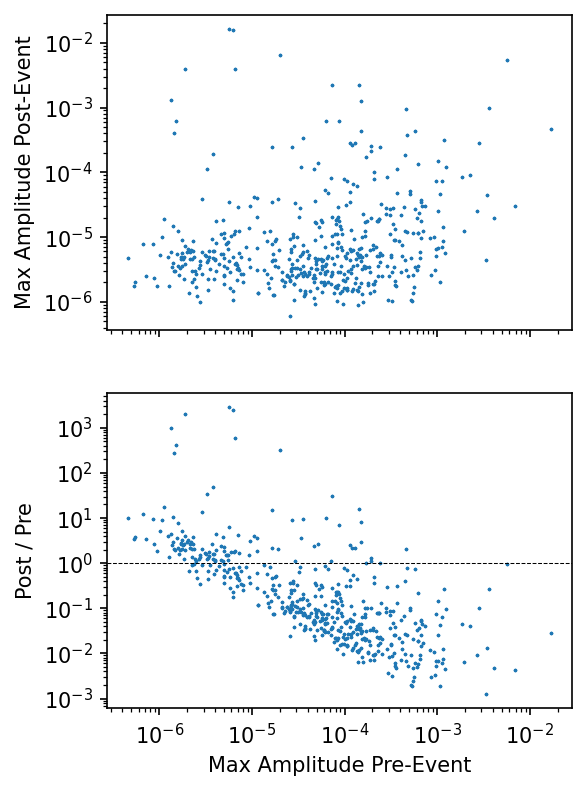

In [ ]:
fig, ax = plt.subplots(2,1, sharex=True, figsize=(4, 6), dpi=150)
ax[0].scatter(np.array(a_max_minus), np.array(a_max_plus), s=0.5)
ax[0].set(
    xscale="log", 
    yscale="log",
    ylabel="Max Amplitude Post-Event",
)

ax[1].scatter(np.array(a_max_minus), np.array(a_max_plus)/np.array(a_max_minus), s=0.5)
ax[1].set(
    xscale="log", 
    yscale="log",
    xlabel="Max Amplitude Pre-Event",
    ylabel="Post / Pre",
)
ax[1].axhline(1, color="k", linestyle="--", lw=0.5)



In [ ]:
# This goes in analysis file

# for each file in REPO 

# load stream

# split into parts

# calculate shaking intensity (e.g. PGV)